In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = South Dakota
state_ab = "sd"

## Data
1. Download all the data in directory "sd_data"
2. Extract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
send_data = "./{}{}_sldu_adopted_2021/sd_sldu_adopted_2021.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2021/sd_sldl_adopted_2021.shp".format(data_folder, state_ab)

In [5]:
def do_smart_repair(df):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df)
    if maup.doctor(df):
        print('smart_repair successful')
            
        # change it back to this UTM for this data
        df = df.to_crs('EPSG:4269')
    else:
        raise Exception('smart_repair failed')
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)
    
    election_df = gpd.GeoDataFrame(election_df, crs="EPSG:4269")
    
    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]
    
    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [9]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [10]:
def add_vest(vest, df, year, population, start_col):    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)

    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated

    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs="EPSG:4269")
    df = gpd.GeoDataFrame(df, crs="EPSG:4269")
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    
    # check if population agrees
    check_population(population, df)
        
    return df

### Read the census data

In [11]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)

In [12]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [13]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')

In [14]:
maup.doctor(population_df)

100%|██████████| 71383/71383 [01:51<00:00, 642.71it/s] 


True

In [15]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [16]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [17]:
population_df.rename(columns=rename_dict, inplace = True)

## Read the vest 20 data

Now using it as a "base pricinct"

In [19]:
def add_vest_base(vest, start_col, year):
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    
    return vest

## Check if vest20 can be used as base

In [20]:
vest20 = gpd.read_file(vest20_data)
if maup.doctor(vest20) != True:
    vest20 = do_smart_repair(vest20)

100%|██████████| 737/737 [00:03<00:00, 244.34it/s]


There are 5 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 862/862 [00:00<00:00, 985.63it/s] 


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████| 737/737 [00:02<00:00, 255.83it/s]


smart_repair successful


In [21]:
vest20.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20USSRROU', 'G20USSDAHL', 'G20HALRJOH', 'G20HALDLUA',
       'G20PUCRHAN', 'G20PUCDEAG', 'G20PUCLSAX', 'geometry'],
      dtype='object')

In [22]:
start_col = 4
vest_base_data = vest20
year = '20'

In [23]:
vest_base = add_vest_base(vest_base_data, start_col, year)

In [24]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████| 737/737 [00:16<00:00, 44.87it/s]


In [25]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [26]:
election_df = gpd.GeoDataFrame(vest_base, crs="EPSG:4269")

In [27]:
election_df.columns

Index(['COUNTYFP', 'HAL20D', 'HAL20R', 'NAME', 'PRE20D', 'PRE20O', 'PRE20R',
       'PUC20D', 'PUC20O', 'PUC20R', 'STATEFP', 'USS20D', 'USS20R', 'VTDST',
       'geometry', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN',
       'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [28]:
pd.DataFrame({
    'pop_col': pop_col,
    'population_df': population_df[pop_col].sum(), 
    'vest_base': vest_base[pop_col].sum(),
    'equal': [x == y for x, y in zip(population_df[pop_col].sum(), vest_base[pop_col].sum())]
})

,pop_col,population_df,vest_base,equal
TOTPOP,TOTPOP,886667,886667,True
HISP,HISP,38741,38741,True
NH_WHITE,NH_WHITE,705583,705583,True
NH_BLACK,NH_BLACK,17441,17441,True
NH_AMIN,NH_AMIN,74595,74595,True
NH_ASIAN,NH_ASIAN,13332,13332,True
NH_NHPI,NH_NHPI,493,493,True
NH_OTHER,NH_OTHER,2050,2050,True
NH_2MORE,NH_2MORE,34432,34432,True
H_WHITE,H_WHITE,9753,9753,True


## Add more vest data

In [29]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [30]:
vest18.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'G18GOVRNOE', 'G18GOVDSUT',
       'G18GOVLEVA', 'G18ATGRRAV', 'G18ATGDSEI', 'G18SOSRBAR', 'G18SOSDFRE',
       'G18TRERHAE', 'G18TREDMAT', 'G18AUDRSAT', 'G18AUDDCOO', 'G18PUCRFIE',
       'G18PUCDFRE', 'G18SPLRBRU', 'G18SPLDHOU', 'G18HALRJOH', 'G18HALDBJO',
       'G18HALLHEN', 'G18HALIWIE', 'geometry'],
      dtype='object')

In [31]:
vest16.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PRECCAS', 'G16USSRTHU', 'G16USSDWIL', 'G16PUCRNEL',
       'G16PUCDRED', 'G16HALRNOE', 'G16HALDHAW', 'geometry'],
      dtype='object')

In [32]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|██████████| 737/737 [00:03<00:00, 232.29it/s]


There are 4 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 867/867 [00:00<00:00, 988.64it/s] 


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████| 737/737 [00:02<00:00, 260.62it/s]


smart_repair successful


100%|██████████| 737/737 [00:16<00:00, 46.01it/s]


population agrees


In [33]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18R', 'AUD18D',
       'AUD18R', 'BVAP', 'COUNTYFP', 'GOV18D', 'GOV18O', 'GOV18R', 'HAL18D',
       'HAL18O', 'HAL18R', 'HAL20D', 'HAL20R', 'HISP', 'HVAP', 'H_2MORE',
       'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'NAME',
       'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI',
       'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE20D', 'PRE20O', 'PRE20R',
       'PUC18D', 'PUC18R', 'PUC20D', 'PUC20O', 'PUC20R', 'SOS18D', 'SOS18R',
       'SPL18D', 'SPL18R', 'STATEFP', 'TOTPOP', 'TRE18D', 'TRE18R', 'USS20D',
       'USS20R', 'VAP', 'VTDST', 'WVAP', 'geometry'],
      dtype='object')

In [34]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|██████████| 747/747 [00:03<00:00, 219.66it/s]


There are 6 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 875/875 [00:00<00:00, 989.99it/s] 


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|██████████| 747/747 [00:02<00:00, 271.05it/s]


smart_repair successful


100%|██████████| 737/737 [00:16<00:00, 45.81it/s]


population agrees


##  Add the district data

In [35]:
send = gpd.read_file(send_data)
hdist = gpd.read_file(hdist_data)

In [36]:
send.head()

,SENATE,geometry
0,1,"POLYGON ((-97.24535 45.15116, -97.24867 45.151..."
1,10,"POLYGON ((-96.71138 43.54248, -96.71138 43.542..."
2,11,"POLYGON ((-96.83072 43.50758, -96.83073 43.508..."
3,12,"POLYGON ((-96.76727 43.46618, -96.76649 43.466..."
4,13,"POLYGON ((-96.72749 43.46984, -96.72749 43.469..."


In [37]:
election_df = add_district(send, "SEND", election_df, "SENATE")

100%|██████████| 35/35 [00:02<00:00, 11.96it/s]


In [38]:
hdist.head()

,ID,DISTRICT,DISTRICTN,geometry
0,1,1,1,"POLYGON ((-97.24535 45.15116, -97.24867 45.151..."
1,2,2,2,"POLYGON ((-96.65102 43.50505, -96.65108 43.505..."
2,3,3,3,"POLYGON ((-98.39221 45.41549, -98.39633 45.415..."
3,4,4,4,"POLYGON ((-97.12081 44.54292, -97.12095 44.542..."
4,5,5,5,"POLYGON ((-97.12739 44.80334, -97.12821 44.803..."


In [39]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICTN")

100%|██████████| 37/37 [00:03<00:00, 11.99it/s]


In [40]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18R', 'AUD18D',
       'AUD18R', 'BVAP', 'COUNTYFP', 'GOV18D', 'GOV18O', 'GOV18R', 'HAL16D',
       'HAL16R', 'HAL18D', 'HAL18O', 'HAL18R', 'HAL20D', 'HAL20R', 'HISP',
       'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER',
       'H_WHITE', 'NAME', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN',
       'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE16D',
       'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'PUC16D', 'PUC16R',
       'PUC18D', 'PUC18R', 'PUC20D', 'PUC20O', 'PUC20R', 'SOS18D', 'SOS18R',
       'SPL18D', 'SPL18R', 'STATEFP', 'TOTPOP', 'TRE18D', 'TRE18R', 'USS16D',
       'USS16R', 'USS20D', 'USS20R', 'VAP', 'VTDST', 'WVAP', 'geometry',
       'SEND', 'HDIST'],
      dtype='object')

### Put the base precinct year after the precinct information column

In [41]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'VTDST':'VTDST'+year,
        'NAME':'NAME'+year}
election_df.rename(columns=base_columns, inplace = True)

In [42]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18R', 'AUD18D',
       'AUD18R', 'BVAP', 'COUNTYFP20', 'GOV18D', 'GOV18O', 'GOV18R', 'HAL16D',
       'HAL16R', 'HAL18D', 'HAL18O', 'HAL18R', 'HAL20D', 'HAL20R', 'HISP',
       'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER',
       'H_WHITE', 'NAME20', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN',
       'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE16D',
       'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'PUC16D', 'PUC16R',
       'PUC18D', 'PUC18R', 'PUC20D', 'PUC20O', 'PUC20R', 'SOS18D', 'SOS18R',
       'SPL18D', 'SPL18R', 'STATEFP20', 'TOTPOP', 'TRE18D', 'TRE18R', 'USS16D',
       'USS16R', 'USS20D', 'USS20R', 'VAP', 'VTDST20', 'WVAP', 'geometry',
       'SEND', 'HDIST'],
      dtype='object')

In [43]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'VTDST'+year,
    'NAME'+year,
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [44]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}/{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

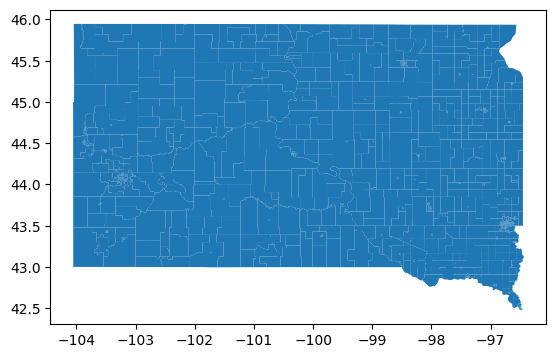

In [45]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()